In [106]:
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from statistics import mean

In [107]:
df = pd.read_csv('clean_tweets_update.csv', usecols=['tweets', 'pos_lems'])

In [108]:
target_df = pd.read_csv('train.csv', usecols=['target'])
target = list(target_df.target)

In [109]:
print(len(target))

7613


In [111]:
train_df, test_df = df.iloc[:len(target_df), :], df.iloc[len(target_df):, :] 
train_df['target'] = target
train_df.drop_duplicates(subset=['tweets'], keep='last', inplace=True)

In [112]:
train_length = len(train_df)
print(train_length)

6782


In [113]:
test_length = len(test_df)
print(test_length)

3263


In [115]:
texts = [train_df.tweets, test_df.tweets]
tweets = pd.concat(texts)
len(tweets)

10045

In [116]:
train_df.tweets = train_df.tweets.replace('at_user', '')
train_df.tweets = train_df.tweets.replace('url_here', '')

## wordcloud

In [10]:
from wordcloud import WordCloud

def plot_wordcloud (df): 
    pos_ = df[df['target']==1]['tweets']
    neg_ = df[df['target']==0]['tweets']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
    wordcloud1 = WordCloud( background_color='black',
                          width=600,
                          height=400).generate(" ".join(pos_)) 

    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Disaster Tweets',color='white',fontsize=40);
    # Non disaster
    wordcloud2 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(neg_)) 

    ax2.imshow(wordcloud2)
    ax2.axis('off')
    ax2.set_title('Non Disaster Tweets',color='white',fontsize=40);

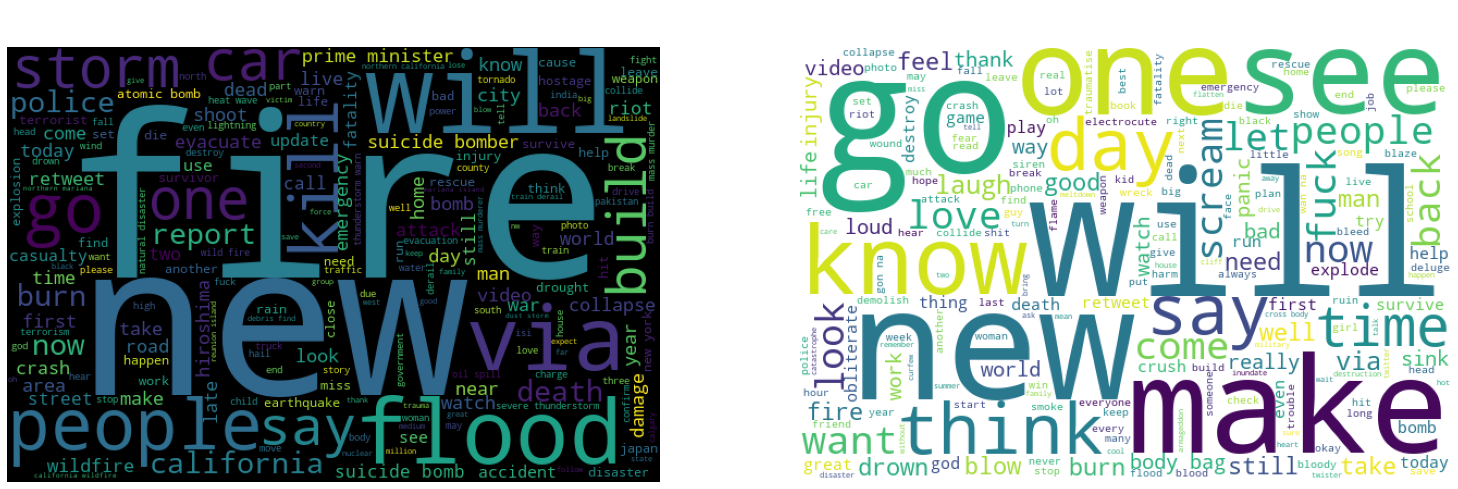

In [65]:
plot_wordcloud(train_df)

# word2vec

In [117]:
def tokenize_text(text):
    tokens = []
    for sent in sent_tokenize(text):
        for word in word_tokenize(sent):
            if len(word)>1:
                tokens.append(word.lower())
    return tokens

In [118]:
tweet_tokens = tweets.apply(tokenize_text)
tweet_tokens = tweet_tokens.replace('at_user', '')
tweet_tokens = tweet_tokens.replace('url_here', '')

In [119]:
word_dict = Counter(tweet_tokens.sum())
# count number of words in corpus
num_words = sum(word_dict[w] for w in word_dict)
print(f'There are {num_words} words in the dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()
vocab_size = len(word_count_sorted)
max_len = max([len(x) for x in tweet_tokens])
print(f'There are {vocab_size} unique words in the dataset')
print("max len of tweets",max_len)
print("min len of tweets",min([len(x) for x in tweet_tokens]))
print("mean len of tweets", mean([len(x) for x in tweet_tokens]))

There are 115838 words in the dataset
There are 13307 unique words in the dataset
max len of tweets 28
min len of tweets 1
mean len of tweets 11.531906421105028


## extract bigrams

In [69]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
#from nltk.corpus import stopwords

In [100]:
def get_documents(text):
    docs = [row.split() for row in text]
    return docs

doc = get_documents(df.tweets)

def sentence_to_bi_grams(sentence):
    return ' '.join(phrases[sentence])

phrases = Phrases(doc, min_count=5, threshold=6, connector_words=ENGLISH_CONNECTOR_WORDS)

frozen_phrases = phrases.freeze()

bigrams = []
for row in doc: 
    parsed_sentence = sentence_to_bi_grams(row)
    bigrams.append(parsed_sentence)


In [101]:
bigrams

['our deed reason this earthquake may allah forgive all',
 'forest_fire near la ronge sask canada',
 'all resident ask shelter place notify by officer no other evacuation or shelter place order expect',
 'people receive wildfire evacuation_order california',
 'just get send this photo from ruby alaska smoke from wildfire pour into school',
 'rocky_fire update california highway close both direction due lake county fire afire wildfire',
 'flood disaster heavy_rain cause flash_flood street manitou colorado spring area',
 'on top hill can_see fire wood',
 'there an emergency evacuation happen now build across street',
 'afraid that tornado come our area',
 'three_people die from heat_wave so_far',
 'haha south tampa get flood hah wait second live south tampa what gon_na do what gon_na do fuck flood',
 'rain flood florida tampa bay tampa or day have lose count',
 'flood bago myanmar we arrive bago',
 'damage school_bus on multi car crash break',
 'what up man',
 'love fruit',
 'summer love

In [14]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction   
import plotly

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly



## uninitialized skipgram

In [16]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [58]:
# uninitializeed model
model_ui_sg = Word2Vec(
        vector_size=36,
        sg=1,
        negative=10,
        sample=1e-2,
        epochs=5,
        window=3,
        workers=cores)
vocab = model_ui_sg.build_vocab(tweet_tokens)

model_ui_sg.train(tweet_tokens, total_examples=model_ui_sg.corpus_count, total_words=num_words, compute_loss=True, epochs=10)

(1256548, 1453220)

In [59]:
model_ui_sg.wv.most_similar(positive="wildfire")

[('california', 0.8427714109420776),
 ('northern', 0.8157798051834106),
 ('raze', 0.7970043420791626),
 ('complex', 0.7879896759986877),
 ('lake', 0.7814660668373108),
 ('palm', 0.7702615857124329),
 ('update', 0.7608448266983032),
 ('township', 0.7602967023849487),
 ('abc', 0.7595618963241577),
 ('acre', 0.7487274408340454)]

In [60]:
model_ui_sg.wv.most_similar(positive="earthquake")

[('anchorage', 0.8473194241523743),
 ('alaska', 0.833899199962616),
 ('winter', 0.8175849914550781),
 ('nepal', 0.8130255341529846),
 ('usgs', 0.8105087280273438),
 ('sismo', 0.8091422915458679),
 ('satellite', 0.8063682317733765),
 ('eq', 0.8059185743331909),
 ('apocalyptic', 0.8058278560638428),
 ('gear', 0.8011044859886169)]

In [61]:
model_ui_sg.get_latest_training_loss()

875114.5625

In [62]:
x_vals, y_vals, labels = reduce_dimensions(model_ui_sg)
plot_function(x_vals, y_vals, labels)

## self initialized skipgram

In [101]:
# uninitializeed model
model_si_sg = Word2Vec(
        sentences=tweet_tokens,
        vector_size=100,
        sg=0,
        min_count=2,
        epochs=5,
        window=3,
        workers=cores)
vocab = model_si_sg.build_vocab(tweet_tokens)

model_si_sg.train(tweet_tokens, total_examples=model_ui_sg.corpus_count, total_words=num_words, compute_loss=True, epochs=5)

(541843, 726610)

In [102]:
model_si_sg.wv.most_similar(positive="earthquake")

[('find', 0.9968253970146179),
 ('miss', 0.9965735673904419),
 ('morning', 0.9963585138320923),
 ('pakistani', 0.9957666993141174),
 ('sun', 0.9956949353218079),
 ('maria', 0.9955110549926758),
 ('sign', 0.9953036308288574),
 ('flash', 0.9952836632728577),
 ('upon', 0.9952817559242249),
 ('three', 0.9952621459960938)]

In [103]:
model_si_sg.wv.most_similar(positive="fire")

[('new', 0.9664496183395386),
 ('northern', 0.9644991159439087),
 ('marians', 0.9591201543807983),
 ('york', 0.9586485624313354),
 ('budget', 0.9574117660522461),
 ('wild', 0.954695999622345),
 ('roosevelt', 0.9542770981788635),
 ('california', 0.9528359770774841),
 ('wildfire', 0.9524645805358887),
 ('raze', 0.9466061592102051)]

In [104]:
model_si_sg.get_latest_training_loss()

103142.40625

In [105]:
x_vals, y_vals, labels = reduce_dimensions(model_si_sg)
plot_function(x_vals, y_vals, labels)

# cbow

In [63]:
# uninitializeed model
model_ui_bow = Word2Vec(
        vector_size=36, 
        min_count=2,
        negative=6,
        sample=1e-2,
        window=3, 
        epochs=5,
        workers=cores)

vocab = model_ui_bow.build_vocab(tweet_tokens)

model_ui_bow.train(tweet_tokens, total_examples=model_ui_bow.corpus_count, total_words=num_words, epochs=10)

(1348333, 1453220)

In [64]:
model_ui_bow.wv.most_similar(positive="wildfire")

[('mariana', 0.9240149259567261),
 ('northern', 0.9221796989440918),
 ('collision', 0.8844216465950012),
 ('river', 0.8836137652397156),
 ('marians', 0.8805608153343201),
 ('kingdom', 0.8800144195556641),
 ('vermont', 0.8799716234207153),
 ('street', 0.8776538968086243),
 ('island', 0.8768037557601929),
 ('derailment', 0.8758067488670349)]

In [25]:
model_ui_bow.wv.most_similar(positive="earthquake")

[('anchorage', 0.9605478644371033),
 ('department', 0.9588204622268677),
 ('memory', 0.9573399424552917),
 ('abandon', 0.9570152163505554),
 ('volcano', 0.955601692199707),
 ('wk', 0.9541385173797607),
 ('lab', 0.9526561498641968),
 ('washington', 0.9518408179283142),
 ('east', 0.9504347443580627),
 ('quake', 0.9494563937187195)]

In [26]:
model_ui_bow.get_latest_training_loss()

0.0

In [27]:
x_vals, y_vals, labels = reduce_dimensions(model_ui_bow)
plot_function(x_vals, y_vals, labels)

In [97]:
# self initialized model
model_si_bow = Word2Vec(
        tweet_tokens,
        vector_size=100, 
        cbow_mean=1,
        min_count=2,
        window=2, 
        workers=cores)
vocab = model_si_bow.build_vocab(tweet_tokens)

model_si_bow.train(tweet_tokens,  total_examples=len(tweet_tokens), total_words=num_words, epochs=10)

(1083802, 1453220)

In [98]:
model_si_bow.wv.most_similar(positive="wildfire")

[('northern', 0.9461382627487183),
 ('marians', 0.9405097365379333),
 ('street', 0.9399799704551697),
 ('mariana', 0.9398275017738342),
 ('complex', 0.932758092880249),
 ('wild', 0.9323949217796326),
 ('corn', 0.9317603707313538),
 ('oil', 0.93008953332901),
 ('nikon', 0.927301824092865),
 ('county', 0.9249475598335266)]

In [99]:
model_si_bow.wv.most_similar(positive="earthquake")

[('indian', 0.9755237698554993),
 ('guardian', 0.9745931625366211),
 ('mountain', 0.9740481376647949),
 ('airplane', 0.9740458130836487),
 ('aircraft', 0.9739638566970825),
 ('page', 0.9721854329109192),
 ('union', 0.9718707799911499),
 ('capture', 0.9717788100242615),
 ('interlaken', 0.9706238508224487),
 ('occupy', 0.9700505137443542)]

In [100]:
x_vals, y_vals, labels = reduce_dimensions(model_si_bow)
plot_function(x_vals, y_vals, labels)

In [65]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model_ui_bow.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = wv['fire']  # Get numpy vector of a word
vector

array([-2.501431  , -0.63520503,  1.8133342 ,  1.6443919 , -0.5557454 ,
       -0.88770735, -0.5299159 , -0.65328604, -0.45770478,  0.17031471,
       -0.38922322,  2.553883  , -2.3272448 , -0.53193176, -2.159784  ,
       -0.47040513, -1.6912287 ,  0.21975398,  1.7961853 , -0.03889235,
        2.399151  ,  0.22277936,  0.07769994,  1.3364588 , -1.4148144 ,
        1.231544  , -0.7099311 ,  2.258203  , -2.835486  , -0.08797634,
        0.22431721,  0.9113754 ,  1.7608671 , -0.49589285,  1.9172946 ,
        0.5459046 ], dtype=float32)